In [1]:
import tensorflow as tf

In [2]:
import os
from pathlib import Path

import zipfile
import random
import numpy as np
import math
from PIL import Image

In [3]:
import matplotlib.pyplot as plt

In [4]:
train_file = 'images_background'
test_file = 'images_evaluation'

In [5]:
BASE_PATH = 'https://raw.githubusercontent.com/brendenlake/omniglot/master/python'

In [6]:
%%time
def get_omniglot():
    
    for file_name in ['images_background', 'images_evaluation']:
        print(f'Getting {file_name} ...', end=' ')
        # creating directory if it is not there
        file_path = os.path.abspath(Path(f'omniglot/{file_name}.zip'))
        if os.path.isfile(file_path):
            print('File already downloaded.. Assuming those are extracted too..')
            continue
        dir_name = os.path.dirname(file_path)
        if not os.path.exists(dir_name):
            os.makedirs(dir_name)

        # download the file to 'omniglot' directory
        dataset_path = tf.keras.utils.get_file(fname=file_path,
                                               origin=f'{BASE_PATH}/{file_name}.zip',
                                               extract=False)

        # extracting to 'omniglot' directory
        with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
            zip_ref.extractall('./omniglot/')

# get the dataset from Github
get_omniglot()

Getting images_background ... File already downloaded.. Assuming those are extracted too..
Getting images_evaluation ... File already downloaded.. Assuming those are extracted too..
Wall time: 1 ms


## Omniglot Loader

In [7]:
dataset_path = 'omniglot'
train_path = os.path.join(dataset_path, 'images_background')
validation_path = os.path.join(dataset_path, 'images_evaluation')

In [8]:
omniglot = Path(dataset_path)
alphabets = list(omniglot.glob('images_background/*'))
number_of_alphabets = len(alphabets)

# shuffle and split the dataset
random.seed(25)
random.shuffle(alphabets)
train_split = 0.8
train_alphabets = alphabets[:int(number_of_alphabets*train_split)]
val_alphabets = alphabets[int(number_of_alphabets*train_split):]
eval_alphabets = list(omniglot.glob('images_evaluation/*'))

# conver them from WIndowsPath to string
train_alphabets = [alpha for alpha in train_alphabets]
val_alphabets = [alpha for alpha in val_alphabets]
eval_alphabets = [alpha for alpha in eval_alphabets]


# combine all alphabets to get the dictionary
alphabets = train_alphabets + val_alphabets + eval_alphabets

# load the folder structure into dictionary
alphabets_dict = {}
for alphabet in alphabets:
    # get images from each character directory
    alphabets_dict[alphabet.name] = {
        character.name: [image.name for image in character.glob('*')]
        for character in alphabet.glob('*')
    }

In [9]:
def get_two_pairs(alphabets):
    """
    Generater to get pairs of images for siamese network
    """
    for alphabet in alphabets:
        alphabet = Path(alphabet.decode())
        # select two characters from the current alhabet
        char1, char2 = random.sample(alphabets_dict[alphabet.name].keys(), 2)
        
        # select 3 images from char1 and 1 image from char2
        same_images = random.sample(alphabets_dict[alphabet.name][char1], 3)
        different_image = random.choice(alphabets_dict[alphabet.name][char2])
        
        # (char1, char1) of same class 
        yield (
            # images pair
            os.path.join(alphabet, char1, same_images[0]),
            os.path.join(alphabet, char1, same_images[1]),
            # label 
            1
        )
        
        # and (char1, char2) of different class
        yield (
            # images pair
            os.path.join(alphabet, char1, same_images[2]),
            os.path.join(alphabet, char2, different_image),
            # label 
            0)

In [10]:
def get_tfds(alphabets):
    return tf.data.Dataset.from_generator(
    generator = get_two_pairs,
    output_types=(tf.string, tf.string, tf.int32),
    args=([str(alpha) for alpha in alphabets],)
)

# train, validation and  test(eval dataset)
train_ds = get_tfds(train_alphabets)
val_ds = get_tfds(val_alphabets)
eval_ds = get_tfds(eval_alphabets)


In [11]:
random.seed(25)
for image1, image2, label in train_ds.take(2):
    print(image1.numpy(),'\n',image2.numpy())
    print(label.numpy())
    print()

b'omniglot\\images_background\\Ojibwe_(Canadian_Aboriginal_Syllabics)\\character07\\0843_01.png' 
 b'omniglot\\images_background\\Ojibwe_(Canadian_Aboriginal_Syllabics)\\character07\\0843_07.png'
1

b'omniglot\\images_background\\Ojibwe_(Canadian_Aboriginal_Syllabics)\\character07\\0843_10.png' 
 b'omniglot\\images_background\\Ojibwe_(Canadian_Aboriginal_Syllabics)\\character13\\0849_16.png'
0



In [12]:
IMG_HEIGHT = 105
IMG_WIDTH = 105

In [13]:
def plot_siamese(image1, image2, label):
    fig, axarr = plt.subplots(1, 2)
    fig.suptitle("Different" if label==0 else "Same", fontsize=16)

    plt.subplot(1,2,1)
    plt.imshow(image1)
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(image2)
    plt.axis('off')

In [14]:
def read_images(file_path1, file_path2, label):
    def read_image(file_path):
        # read the image from file as raw string
        img = tf.io.read_file(filename=file_path)

        # convert the string image to 3D uint8 tensor
        img = tf.image.decode_jpeg(contents=img, channels=3)

        # convert that image to float32
        img = tf.image.convert_image_dtype(image=img, dtype=tf.float32)
        
        return tf.image.resize(images=img, size=[IMG_HEIGHT, IMG_WIDTH])
    
    
    return read_image(file_path1), read_image(file_path2), label

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

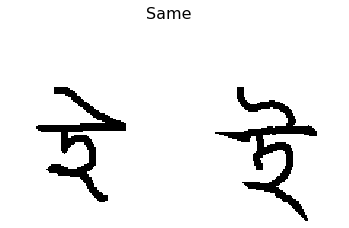

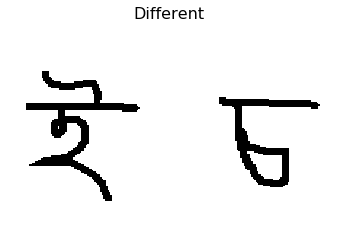

In [16]:
ds = val_ds.map(read_images, num_parallel_calls=AUTOTUNE)

for image1, image2, label in ds.take(2):
    plot_siamese(image1, image2, label)

In [17]:
BATCH_SIZE = 32

In [18]:
def prepare_dataset(ds):
    
    # read images from strings
    ds = ds.map(read_images, num_parallel_calls=AUTOTUNE)
    
    # repeat the train dataset hoping that all the classes are
    # covered for an alphabet.
    ds = ds.repeat(count=32)
    
    # to train the model in batches
    ds = ds.batch(batch_size=BATCH_SIZE)
    
    # prefetch: called after batching so that batches are
    # pre-fetched in background while training
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    return ds

# prepare dataset for training, validation and testing(evaluating)
train_ds_final = prepare_dataset(train_ds)
val_ds_final = prepare_dataset(val_ds)
eval_ds_final = prepare_dataset(eval_ds)

In [19]:
for image1s, image2s, labels in train_ds_final.take(1):
    print(image1s.shape, image2s.shape)

(32, 105, 105, 3) (32, 105, 105, 3)


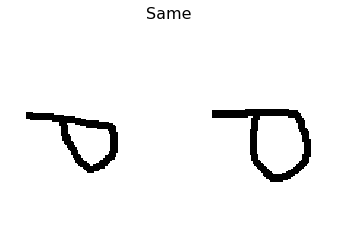

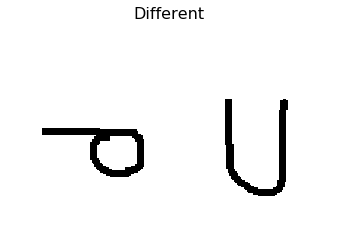

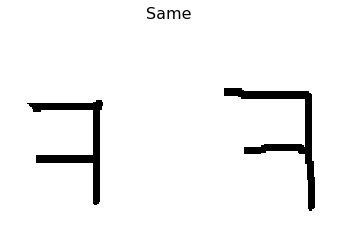

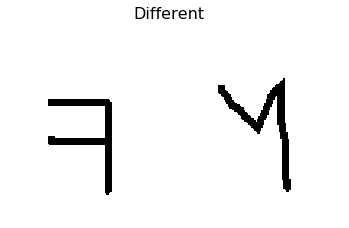

In [20]:
for image1, image2, label in zip(image1s[:4], image2s[:4], labels[:4]):
    plot_siamese(image1, image2,label)

## Model

In [21]:
# Siamese Neural Networks for One-shot Image Recognition
### https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf


In [22]:
INPUT_SHAPE = (105, 105, 3)
INPUT_SHAPE

(105, 105, 3)

In [23]:
from tensorflow.keras import layers

In [24]:
def conv_block(name, filters, kernel_size, l2_reg_factor,):
    """Same as original paper but with Batch """
    with tf.name_scope(name=name):
        return tf.keras.Sequential(layers=[
            layers.Conv2D(filters=filters, kernel_size=kernel_size,
                          padding='valid',
                          kernel_regularizer=tf.keras.regularizers.l2(l2_reg_factor)),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.MaxPool2D(pool_size=(2,2))
        ], name=name)

In [25]:
class L1DistanceLayer(tf.keras.layers.Layer):
    
    def __init__(self, **kwargs):
        super(L1DistanceLayer, self).__init__(**kwargs)
    
    def call(self, inputs):
        return tf.abs(inputs[0] - inputs[1])

In [26]:
class Siamese(tf.keras.Model):
    
    def __init__(self, **kwargs):
        
        super(Siamese, self).__init__(**kwargs)
        
        # CNN encoder
        self.encoder = tf.keras.Sequential(layers=[
            conv_block(name='Conv1', filters=64, kernel_size=(10,10), l2_reg_factor=1e-2),
            conv_block(name='Conv2', filters=128, kernel_size=(7,7), l2_reg_factor=1e-2),
            conv_block(name='Conv3', filters=128, kernel_size=(4,4), l2_reg_factor=1e-2),
            conv_block(name='Conv4', filters=256, kernel_size=(4,4), l2_reg_factor=1e-2),
            layers.Flatten()
        ], name='encoder')
        
        # dense layer
        self.dense = tf.keras.layers.Dense(units=4096, activation='sigmoid',
                                           kernel_regularizer=tf.keras.regularizers.l2(1e-4),
                                          name='dense')
        # l1-distance layer
        self.l1_distance = L1DistanceLayer(name='distance_layer')
        
        # output layer
        self.logits = tf.keras.layers.Dense(units=1, activation=None)
    
    @tf.function
    def call(self, inputs, training=False):
        
        # flattened outputs of both images
        encoded_image1s = self.dense(self.encoder(inputs[0], training=training))
        encoded_image2s = self.dense(self.encoder(inputs[1], training=training))
        
        # get l1-distance between those images and return the logits
        return self.logits(self.l1_distance(inputs=(encoded_image1s, encoded_image2s)))

    
    def compile(self, loss_fn, optimizer):
        """Initialize loss_fn and the optimizer"""
        self.loss_fn, self.optimizer = loss_fn, optimizer


    def get_config(self):
        """returns: loss function and optimizer and acc_fn for this model"""
        return {
            "loss_fn": self.loss_fn,
            "optimizer": self.optimizer,
        }

    @tf.function
    def train_step(self, batch, labels, train_loss, train_acc):
        with tf.GradientTape() as tape:
            # recored all the values on a tape in forward pass
            logits = self.call(batch, training=True)
            loss = self.loss_fn(y_true=labels, y_pred=logits)

        # backward pass : grad of parameters w.r.t Loss
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(grads_and_vars=zip(gradients, self.trainable_variables))
        
        train_loss(loss)  # Mean Metric : Just update the loss
        train_acc(y_true=labels, y_pred=tf.nn.sigmoid(logits))  # accuracy Metric
    
    @tf.function
    def test_step(self, batch, labels, test_loss, test_acc):
        """ Run the Inference for the given batch and update the metrics """
        
        logits = self.call(batch, training=False)
        loss = self.loss_fn(y_true=labels, y_pred=logits)
        
        test_loss(loss)  # Mean Metric - just update the loss
        test_acc(y_true=labels, y_pred=tf.nn.sigmoid(logits))  # Accuracy Metric
 

In [27]:
model = Siamese(name='Siamese')
# update the loss function and optiizer for the model
model.compile(loss_fn=tf.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.optimizers.SGD(nesterov=True))

In [28]:
# Train and test(validation) metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_acc = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')

val_loss = tf.keras.metrics.Mean(name='validation_loss')
val_acc = tf.keras.metrics.BinaryAccuracy(name='validation_accuracy')

## Training

### Creating & loading check points for this model
- https://www.tensorflow.org/guide/checkpoint

In [29]:
model.optimizer.iterations  # before loading checkpoint

<tf.Variable 'iter:0' shape=() dtype=int64, numpy=0>

In [30]:
# define model checkpoint with objects that we want to save
# as attriutes to the checkpoint object
model_ckpt = tf.train.Checkpoint(step=tf.Variable(0), epoch=tf.Variable(0),
                                 optimizer=model.optimizer,
                                 model=model)

# manager to manage multiple checkpoints. Here, we keep only lateset 10 model check points
model_ckpt_manager = tf.train.CheckpointManager(model_ckpt, './siamese_tf_ckpts',
                                                max_to_keep=10)


In [31]:
# load the model (latest checkpoint)
# load the model check point
model_ckpt.restore(model_ckpt_manager.latest_checkpoint)

if model_ckpt_manager.latest_checkpoint:
    print("Restored from {}".format(model_ckpt_manager.latest_checkpoint))
else:
     print("Training from scratch.")

Restored from ./siamese_tf_ckpts\ckpt-75


In [32]:
model_ckpt.step.numpy(), model_ckpt.epoch.numpy()

(7200, 150)

In [33]:
model.optimizer.iterations  # After loading checkpoint

<tf.Variable 'iter:0' shape=() dtype=int64, numpy=7200>

In [34]:
model_ckpt.epoch, model_ckpt.step

(<tf.Variable 'Variable:0' shape=() dtype=int32, numpy=150>,
 <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=7200>)

### Training

In [35]:
# Creating summary writers for this model
wtrain = tf.summary.create_file_writer(logdir="logs/siamese/train")
wtest = tf.summary.create_file_writer(logdir="logs/siamese/test")

In [36]:
from time import perf_counter

In [37]:
EPOCHS = 50
log_freq = 10  # for every few optimizer iterations. ie., weight updates
ckpt_freq = 100 # for every few optimizer iterations. ie., weight updates

global_st = perf_counter()  # Counter before training starts

# take last epoch trained from model checkpoint
last_epoch = model_ckpt.epoch.numpy()
for epoch in range(last_epoch, last_epoch+EPOCHS, 1):    
    # To count the time
    local_st = perf_counter()
    
    # Reset the metrics at the start of the every epoch
    train_loss.reset_states()
    train_acc.reset_states()
    val_loss.reset_states()
    val_acc.reset_states()
    
    # training loop, It will update the metrics
    for image1s, image2s, labels in train_ds_final:
        model.train_step(batch=(image1s, image2s), labels=labels,
                         train_loss=train_loss, train_acc=train_acc)
        
        # log the train metrics 
        if tf.equal(model.optimizer.iterations % log_freq, 0):
            with tf.name_scope('Training'):
                with wtrain.as_default():
                    tf.summary.scalar("Loss", train_loss.result().numpy(),
                                      step=model.optimizer.iterations)
                    tf.summary.scalar("Accuracy", train_acc.result().numpy(),
                                      step=model.optimizer.iterations)
                    wtrain.flush()
        
        # save the model for every ckpt_freq steps
        model_ckpt.step.assign_add(1)
        if tf.equal(model_ckpt.step % ckpt_freq, 0):
            save_path = model_ckpt_manager.save()
            print("Saved checkpoint for step {}: {}".format(model_ckpt.step.numpy(), save_path))

    
    # test loop, and it will update the metrics as well
    for image1s, image2s, labels in val_ds_final:
        model.test_step(batch=(image1s, image2s), labels=labels,
                        test_loss=val_loss, test_acc=val_acc)
    
    # Update the model checkpoint epoch
    model_ckpt.epoch.assign_add(1)
    
    # Update the train and validation for this epoch
    with tf.name_scope("Per_Epoch"):
        
        with wtrain.as_default():
            tf.summary.scalar("Loss", train_loss.result().numpy(),
                              step=model_ckpt.epoch.numpy())
            tf.summary.scalar("Accuracy", train_acc.result().numpy(),
                              step=model_ckpt.epoch.numpy())
            wtrain.flush()

        with wtest.as_default():
            tf.summary.scalar("Loss", val_loss.result().numpy(),
                              step=model_ckpt.epoch.numpy())
            tf.summary.scalar("Accuracy", val_acc.result().numpy(),
                              step=model_ckpt.epoch.numpy())
            wtest.flush()
    
    
    template = "\nEpoch:{}/{} loss:{:0.5f}  acc:{:0.4f}  "
    template += "val_loss:{:0.5f}  val_acc:{:0.4f} - {:0.0f}s(total: {:0.0f}s)"
    print(template.format(epoch+1, last_epoch+EPOCHS,
                      train_loss.result().numpy(), train_acc.result().numpy(), 
                      val_loss.result().numpy(), val_acc.result().numpy(),
                      perf_counter()-local_st, perf_counter()-global_st))


# Saving model at the end of training
model_ckpt.step.assign(model.optimizer.iterations.numpy())
save_path = model_ckpt_manager.save()
print("Saved checkpoint at the end of epoch {}: {}".format(int(model_ckpt.step), save_path))


Epoch:151/200 loss:0.22218  acc:0.9251  val_loss:0.38451  val_acc:0.8255 - 14s(total: 14s)

Epoch:152/200 loss:0.20316  acc:0.9310  val_loss:0.35224  val_acc:0.8750 - 12s(total: 27s)
Saved checkpoint for step 7300: ./siamese_tf_ckpts\ckpt-76

Epoch:153/200 loss:0.20110  acc:0.9368  val_loss:0.40362  val_acc:0.8333 - 13s(total: 39s)

Epoch:154/200 loss:0.21622  acc:0.9238  val_loss:0.29969  val_acc:0.8698 - 9s(total: 48s)
Saved checkpoint for step 7400: ./siamese_tf_ckpts\ckpt-77

Epoch:155/200 loss:0.19620  acc:0.9329  val_loss:0.30878  val_acc:0.8672 - 13s(total: 61s)

Epoch:156/200 loss:0.19634  acc:0.9329  val_loss:0.32814  val_acc:0.8620 - 10s(total: 71s)
Saved checkpoint for step 7500: ./siamese_tf_ckpts\ckpt-78

Epoch:157/200 loss:0.20709  acc:0.9310  val_loss:0.42142  val_acc:0.8255 - 12s(total: 83s)

Epoch:158/200 loss:0.20801  acc:0.9349  val_loss:0.36295  val_acc:0.8438 - 8s(total: 91s)
Saved checkpoint for step 7600: ./siamese_tf_ckpts\ckpt-79

Epoch:159/200 loss:0.17453  a